### SUMMARY EXECUTIVE
- RandomForestRegressor has decaying predictive power over stage (1-4)
- Seems like only `stage`, `round_num` are important features

In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
%load_ext autoreload
%autoreload 2

### 0. Prepare Dataset

In [2]:
csv_path = '../dataset/topagent_dataset/100_games_wconsec.csv'
df = pd.read_csv(csv_path)
df.shape

(799600, 11)

In [3]:
def group_round(round_num):
    if round_num <= 500:
        stage = 1
    elif round_num <= 1000:
        stage = 2
    elif round_num <= 1500:
        stage = 3
    else:
        stage = 4
    return stage

In [4]:
df['stage'] = df.round_num.apply(lambda n: group_round(n))

In [5]:
df[df.stage == 1].shape, df[df.stage == 2].shape, df[df.stage == 3].shape

((200000, 12), (200000, 12), (200000, 12))

In [6]:
df = df.sample(frac = 1, random_state = 0).reset_index(drop = True)

In [7]:
list(df)

['round_num',
 'machine_id',
 'agent_id',
 'n_pulls_self',
 'n_success_self',
 'n_pulls_opp',
 'payout',
 'n_consec2_opp',
 'n_consec3_opp',
 'n_consec4_opp',
 'n_consec5_opp',
 'stage']

In [8]:
predictor_cols = [
    'stage', 'n_pulls_self', 'n_success_self', 'n_pulls_opp', 
    'n_consec2_opp', 'n_consec3_opp', 'n_consec4_opp', 'n_consec5_opp'
]
target_col = 'payout'

In [9]:
X, y = df[predictor_cols], df[target_col]
X.shape, y.shape

((799600, 8), (799600,))

### How many Rows with Consec K != 0

In [29]:
X[X.n_consec2_opp > 0].shape[0] / X.shape[0]

0.8569184592296148

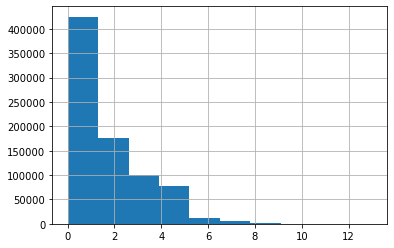

In [34]:
X.n_consec2_opp.hist();

In [30]:
X[X.n_consec3_opp > 0].shape[0] / X.shape[0]

0.7357841420710355

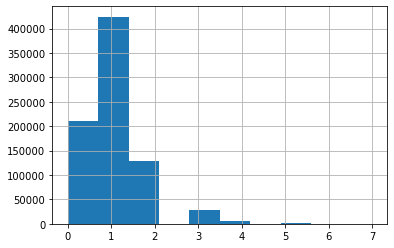

In [35]:
X.n_consec3_opp.hist();

In [31]:
X[X.n_consec4_opp > 0].shape[0] / X.shape[0]

0.6099224612306153

In [32]:
X[X.n_consec5_opp > 0].shape[0] / X.shape[0]

0.4965845422711356

### 1. Cross Validation Score per Stage (1/2/3/4)

In [10]:
from sklearn.model_selection import KFold

rfr_kwargs = {
    'criterion': 'mse', 
    'max_depth': 9, 
    'min_samples_leaf': 2}

In [11]:
def cv_train(X, y, cv_n):
    X = X.copy().to_numpy()
    y = y.copy().to_numpy()
    
    test_scores = []
    kf = KFold(
        n_splits = 4, 
        random_state = 0, 
        shuffle = True)
    kf.get_n_splits(X)
    
    scores = []
    for idx, (train_idxs, test_idxs) in enumerate(kf.split(X)):
        print(f'{idx}-th CV starting...')
        train_X, test_X = X[train_idxs], X[test_idxs]
        train_y, test_y = y[train_idxs], y[test_idxs]
        
        rfr = RandomForestRegressor(**rfr_kwargs)
        rfr.fit(train_X, train_y)
        train_y_pred = rfr.predict(train_X)
        test_y_pred = rfr.predict(test_X)
        
        train_score = r2_score(train_y, train_y_pred)
        test_score = r2_score(test_y, test_y_pred)
        scores.append((train_score, test_score))
        
    train_scores = [train_score for train_score, test_score in scores]
    test_scores = [test_score for train_score, test_score in scores]
    train_r2 = sum(train_scores) / len(train_scores)
    test_r2 = sum(test_scores) / len(test_scores)
    print(f'train r2: {train_r2}, test r2: {test_r2}')
    
    return rfr, train_r2, test_r2

In [12]:
outs = {}
for stage_n in [1, 2, 3, 4]:
    print(f'stage_n: {stage_n}')
    stage_df = df[df.stage == stage_n]
    sub_cols = [col for col in predictor_cols if col != 'stage']
    stage_X, stage_y = stage_df[sub_cols], stage_df[target_col]
    rfr, train_r2, test_r2 = cv_train(stage_X, stage_y, cv_n = 4)
    outs[stage_n] = {'rfr': rfr, 'train_r2': train_r2, 'test_r2': test_r2}

stage_n: 1
0-th CV starting...
1-th CV starting...
2-th CV starting...
3-th CV starting...
train r2: 0.3552581240237926, test r2: 0.35147867126166626
stage_n: 2
0-th CV starting...
1-th CV starting...
2-th CV starting...
3-th CV starting...
train r2: 0.30920264401721764, test r2: 0.3001698224785707
stage_n: 3
0-th CV starting...
1-th CV starting...
2-th CV starting...
3-th CV starting...
train r2: 0.2964204148786727, test r2: 0.28318132924763956
stage_n: 4
0-th CV starting...
1-th CV starting...
2-th CV starting...
3-th CV starting...
train r2: 0.24322639681808791, test r2: 0.22179316833920248


### 2a. Train without Filtering by Stage

In [20]:
X.shape

(799600, 8)

In [15]:
full_rfr, _, _ = cv_train(X, y, cv_n = 4)

0-th CV starting...
1-th CV starting...
2-th CV starting...
3-th CV starting...
train r2: 0.6972614809793961, test r2: 0.6958417755963271


### 2b. Train with only `stage = 1 or stage = 2`

In [21]:
alt_df = df[(df.stage == 1) | (df.stage == 2)]
alt_X, alt_y = alt_df[predictor_cols], alt_df[target_col]

In [22]:
alt_rfr, _, _ = cv_train(alt_X, alt_y, cv_n = 4)

0-th CV starting...
1-th CV starting...
2-th CV starting...
3-th CV starting...
train r2: 0.5106015938658521, test r2: 0.5079346426946529


### 3a. Partial Dependency Plot

In [23]:
from sklearn.inspection import plot_partial_dependence

In [24]:
full_rfr.predict([[1, 13, 10, 4, 0, 0, 0, 0], [1, 4, 2, 13, 0, 0, 0, 0]])

array([0.46021368, 0.4854675 ])

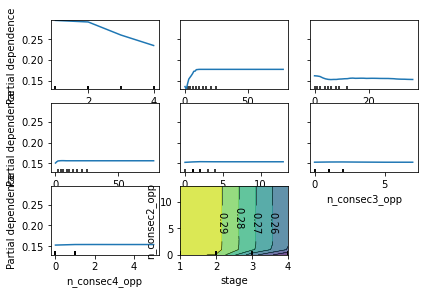

In [25]:
plot_partial_dependence(rfr, X, [0, 1, 2, 3, 4, 5, 6, (0, 4)]);
plt.tight_layout()

### 3b. Feature Importance

Feature ranking:
1. feature 0 (0.815647)
2. feature 1 (0.087893)
3. feature 2 (0.058047)
4. feature 3 (0.024898)
5. feature 4 (0.009793)
6. feature 5 (0.002584)
7. feature 6 (0.000679)
8. feature 7 (0.000458)


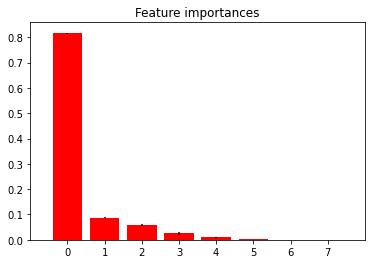

In [26]:
importances = full_rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in full_rfr.estimators_],
             axis = 0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(
    range(X.shape[1]), importances[indices],
    color = "r", yerr = std[indices], align = "center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()